In [1]:
from astropy.time import Time, TimeDelta
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
import h5py
import numpy as np
import os
import glob
import pandas as pd
import scipy.stats as st
import sunpy.coordinates.sun as sn
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from palettable.colorbrewer.qualitative import Dark2_5, Set1_3
import astropy.units as u

import huxt as H
import huxt_analysis as HA
import huxt_inputs as HIN
import GeoModelUncertainty as gmu

Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071


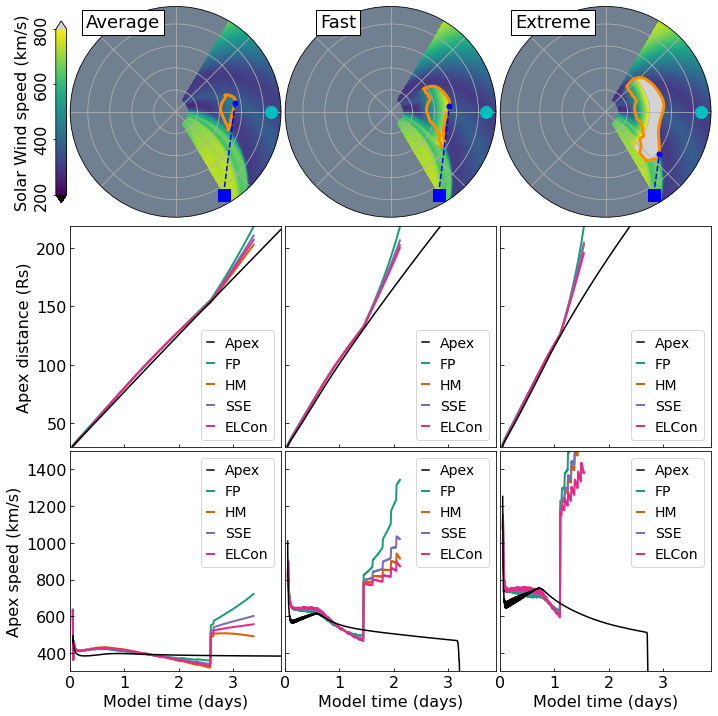

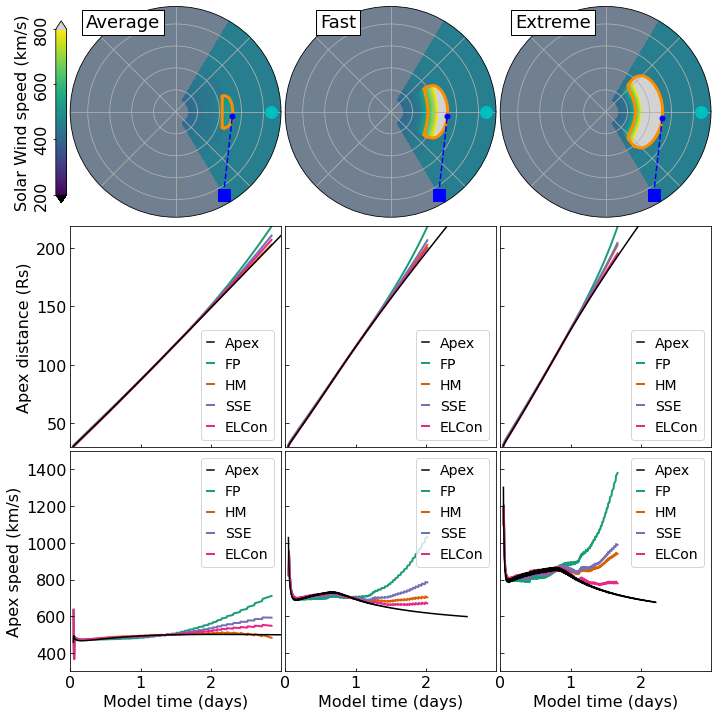

In [10]:
for wind_type in ['structured', 'uniform']:
        
    # Set up HUXt to run all three scenarios in uniform wind, then plot the kinematics out.
    fig, ax = plt.subplots(figsize=(10, 10))
    ax1 = plt.subplot(331, projection='polar')
    ax2 = plt.subplot(332, projection='polar')
    ax3 = plt.subplot(333, projection='polar')
    axt = [ax1, ax2, ax3]
    ax4 = plt.subplot(334)
    ax5 = plt.subplot(335)
    ax6 = plt.subplot(336)
    axm = [ax4, ax5, ax6]
    ax7 = plt.subplot(337)
    ax8 = plt.subplot(338)
    ax9 = plt.subplot(339)
    axb = [ax7, ax8, ax9]

    cme_scenarios = gmu.load_cme_scenarios()

    t_arr_stats = []
    r_arr_stats = []

    for i, s_key in enumerate(['average', 'fast', 'extreme']):

        scenario = cme_scenarios[s_key]
        start_time = Time('2008-06-10T00:00:00')
        cr_num = np.fix(sn.carrington_rotation_number(start_time))
        ert = H.Observer('EARTH', start_time)
        vr_in = HIN.get_MAS_long_profile(cr_num, ert.lat.to(u.deg))
        if wind_type == 'uniform':
            vr_in = vr_in*0 + 400*(u.km/u.s)

        model = H.HUXt(v_boundary=vr_in, cr_num=cr_num, cr_lon_init=ert.lon_c, latitude=ert.lat.to(u.deg),
                       lon_start=300*u.deg, lon_stop=60*u.deg, simtime=5*u.day, dt_scale=1)

        t_launch = (1*u.hr).to(u.s)
        cme = H.ConeCME(t_launch=t_launch, longitude=0*u.deg, latitude=model.latitude.to(u.deg),
                        width=scenario['width'], v=scenario['speed'], thickness=0.1*u.solRad)

        # Solve HUXt and get CME object
        model.solve([cme])
        cme = model.cmes[0]

        #Track the CMEs apex kinematics
        apex = gmu.compute_apex_profile(cme)

        # Observe the CME from L4 and L5
        l5obs = gmu.Observer(model, 300.0*u.deg, el_min=4.0, el_max=60.0, color='b', name='L5')

        observer_list = [l5obs]

        # Plot solution when CME gets to 100rs
        id_t = np.argmin(np.abs(apex['r'] - 130*u.solRad.to(u.km)))
        gmu.plot_huxt_multi(axt[i], model.time_out[id_t], model, observer_list, add_observer=True, add_flank=True)

        # Plot the apex and geometric model kinematics profiles        
        t = apex['model_time'].values*u.s
        r = apex['r'].values*u.km
        v = apex['v'].values*u.km/u.s
        id_max = r >= 0.999*np.nanmax(r)
        r[id_max] = np.NaN*r.unit
        v[id_max] = np.NaN*v.unit
        
        axm[i].plot(t.to(u.d), r.to(u.solRad), 'k-', label='Apex', zorder=2)
        axb[i].plot(t.to(u.d), v, 'k-', label='Apex', zorder=2)

        names = ['FP', 'HM', 'SSE', 'ELCon']
        for j, obs in enumerate([l5obs.fp, l5obs.hm, l5obs.sse, l5obs.elp]):
            t = obs['model_time'].values*u.s
            r = obs['r_apex'].values*u.km
            v = obs['v_apex'].values*u.km/u.s
            
            # remove the first velocity values due to noise in computing gradient at the edge.
            id_first_v = np.argwhere(np.isfinite(v))[0][0]
            v[id_first_v] = np.NaN*v.unit
            
            axm[i].plot(t.to(u.d), r.to(u.solRad), '-', color=Dark2_5.mpl_colors[j], label=names[j], linewidth=2, zorder=1)
            axb[i].plot(t.to(u.d), v, '-', color=Dark2_5.mpl_colors[j], label=names[j], linewidth=2, zorder=1)

        arrival_stats = cme.compute_arrival_at_body('Earth')
        t_arr_stats.append(arrival_stats['t_transit'].value)
        r_arr_stats.append(arrival_stats['hit_rad'].value)

    t_max = np.max(t_arr_stats)
    r_max = np.max(r_arr_stats)
    v_max = 1500

    # Fix inconvenient x-limit for plot formatting
    if wind_type=='uniform':
        t_max = 2.99

    for a in axm:
        a.set_xlim(0, t_max)
        a.set_ylim(30, r_max)
        a.set_xticklabels([])
        a.legend(loc=4, handlelength=0.5, fontsize=14)
        a.tick_params(direction='in')

    for a in axb:
        a.set_xlim(0, t_max)
        a.set_ylim(300, v_max)
        a.legend(loc=1, handlelength=0.5, fontsize=14)
        a.tick_params(direction='in')
        a.set_xlabel('Model time (days)')

    # Remove uncessary y labels
    for am, ab in zip(axm[1:], axb[1:]):
        am.set_yticklabels([])
        ab.set_yticklabels([])

    axm[0].set_ylabel('Apex distance (Rs)')
    axb[0].set_ylabel('Apex speed (km/s)')

    for a, lab in zip(axt, ['Average', 'Fast', 'Extreme']):
        a.text(0.25, 0.9, lab, horizontalalignment='center', transform=a.transAxes, fontsize=18 ,bbox=dict(facecolor='white'))

    fig.subplots_adjust(left=0.1, bottom=0.06, right=0.99, top=0.99, wspace=0.02, hspace=0.02)
    
    # Add on colorbar for the HUXt maps
    mymap = mpl.cm.viridis
    mymap.set_over('lightgrey')
    mymap.set_under([0, 0, 0])
    norm = mpl.colors.Normalize(vmin=200,vmax=800)
    smp = mpl.cm.ScalarMappable(norm=norm, cmap=mymap)

    pos = ax1.get_position()
    dw = 0.02
    dh = 0.02
    left = pos.x0 - dw
    bottom = pos.y0 + dh
    width = 0.015
    height = pos.height - 2*dh
    cbaxes = fig.add_axes([left, bottom, width, height])
    cbar = fig.colorbar(smp, cax=cbaxes, orientation='vertical', extend='both')

    cbaxes.yaxis.set_ticks_position('left')
    cbaxes.yaxis.set_label_position('left')
    cbar.set_label('Solar Wind speed (km/s)')

    ticks = np.arange(200, 810, 200)
    labels = [str(tick) for tick in ticks]
    cbaxes.set_yticklabels(labels, rotation=90, va='center')

    # Save 
    #proj_dirs = gmu.get_project_dirs()        
    #fig_name = 'one_observer_all_geomods_{}.pdf'.format(wind_type)
    #fig_path = os.path.join(proj_dirs['paper_figures'], fig_name)
    #fig.savefig(fig_path, format='pdf')
    #plt.close('all')

17

In [52]:
data_path = "C:/Users/yq904481/research/repos/GeoModelUncertainty/data/out_data/CME_scenarios_simulation_results.hdf5"
data = h5py.File(data_path, 'r')

gm_labels = {'fp':'FP', 'hm':'HM', 'sse':'SSE', 'elp':'ELCon'}

    
#dr = 0.025
#r_out = np.arange(0.15, 0.5 + dr, dr)
r_out = np.array([0.2, 0.3, 0.4, 0.5])
err_arr = np.zeros((r_out.size, 100))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

scenario = data['average']
scale = 1*u.AU.to(u.km)

r_path = "/".join(['cme_apex','r'])
obs = 'Observer 270.00'
gm = 'elp'
rg_path = "/".join(['observers', obs, gm, 'r_apex'])

r_int_limit = 0.5
sum_err = []
lines = []

ii=0
for r_key, run in scenario.items():

    # Get the HUXt and GM apex distances
    r = run[r_path][()]/scale
    rg = run[rg_path][()]/scale

    # Find only the valid values in each and compute the error and absolute error
    id_good = np.isfinite(r) & np.isfinite(rg)
    r = r[id_good]
    rg = rg[id_good]
    err = rg - r

    # interp at the out r vals and save
    err_arr[:, ii] = np.interp(r_out, r, err)
    ii += 1
    
    # Integrate the errors up to r_int_limit, save to array
    id_sub = r <= r_int_limit
    err_intg = np.trapz(err[id_sub], r[id_sub])
    sum_err.append(err_intg)

    # Update the plot with these data
    ax[0].plot(r, err, '-', color='darkgrey', zorder=1)
    h = ax[0].plot(r[id_sub], err[id_sub], '-', color='darkgrey', zorder=1)
    lines.append(h[0])

# Add integration limit to axes
ax[0].vlines(r_int_limit, -1, 1, colors='k', linestyles='dashed', linewidth=2)
ax[0].hlines(0, 0.1, 0.9, colors='k', linestyles='dotted', linewidth=2)

# Update line colors according to integrated error
sum_err = np.array(sum_err)

e_min = sum_err.min()
e_max = sum_err.max()
e_supermax = np.max([np.abs(e_min), e_max])
norm = mpl.colors.Normalize(vmin=-e_supermax, vmax=e_supermax)
cmap = mpl.cm.PiYG
for h, e in zip(lines, sum_err):
    h.set_color(cmap(norm(e)))

ylabel = "{} apex error, $\epsilon _{{{}}}$, (Au)".format(gm_labels[gm], gm_labels[gm])
ax[0].set_ylabel(ylabel)

ax[0].set_xlim(0.1, 0.9)
ax[0].set_ylim(-0.1, 0.25)
ax[0].set_xlabel('HUXt apex (Au)')

# Add histogram to last panel
bins = np.arange(-0.01, 0.02, 0.002)
ax[1].hist(sum_err, bins, density=True, color='skyblue')
# Add mean error
avg_err = np.mean(sum_err)
ax[1].vlines(0, 0, 400, colors='k', linestyles='-.', linewidth=2)
ax[1].vlines(avg_err, 0, 400, colors='r', linestyles='--', linewidth=2, label='$\\langle E_{{{}}} \\rangle$'.format(gm_labels[gm]))
ax[1].set_xlabel('Integrated {} apex error, $E_{{{}}}$'.format(gm_labels[gm], gm_labels[gm]))

# Format axes
ax[1].set_xlim(-0.0045, 0.019)
ax[1].set_ylim(0, 175)        
ax[1].set_ylabel('Density')    
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')
ax[1].legend()

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.925, top=0.85, wspace=0.01)

# Add the colorbar to ax[0] for the errors
pos = ax[0].get_position()
dw = 0.005
dh = 0.005
left = pos.x0 + dw
bottom = pos.y1 + dh
wid = pos.width - 2 * dw
hi_cbaxes = fig.add_axes([left, bottom, wid, 0.02])
smp = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar1 = fig.colorbar(smp, cax=hi_cbaxes, orientation='horizontal')
cbar1.ax.set_xlabel('Integrated {} apex error, $E_{{{}}}$'.format(gm_labels[gm], gm_labels[gm]))
cbar1.ax.xaxis.tick_top()
cbar1.ax.xaxis.set_label_position('top')

# save and close
proj_dirs = gmu.get_project_dirs()        
fig_name = "{}_integration_example_for_reviewers.png".format(err_type)
fig_path = os.path.join(proj_dirs['paper_figures'], fig_name)
fig.savefig(fig_path, format='png')
plt.close('all')

data.close()



In [30]:
r_out

array([0.15 , 0.175, 0.2  , 0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 ,
       0.375, 0.4  , 0.425, 0.45 , 0.475, 0.5  ])

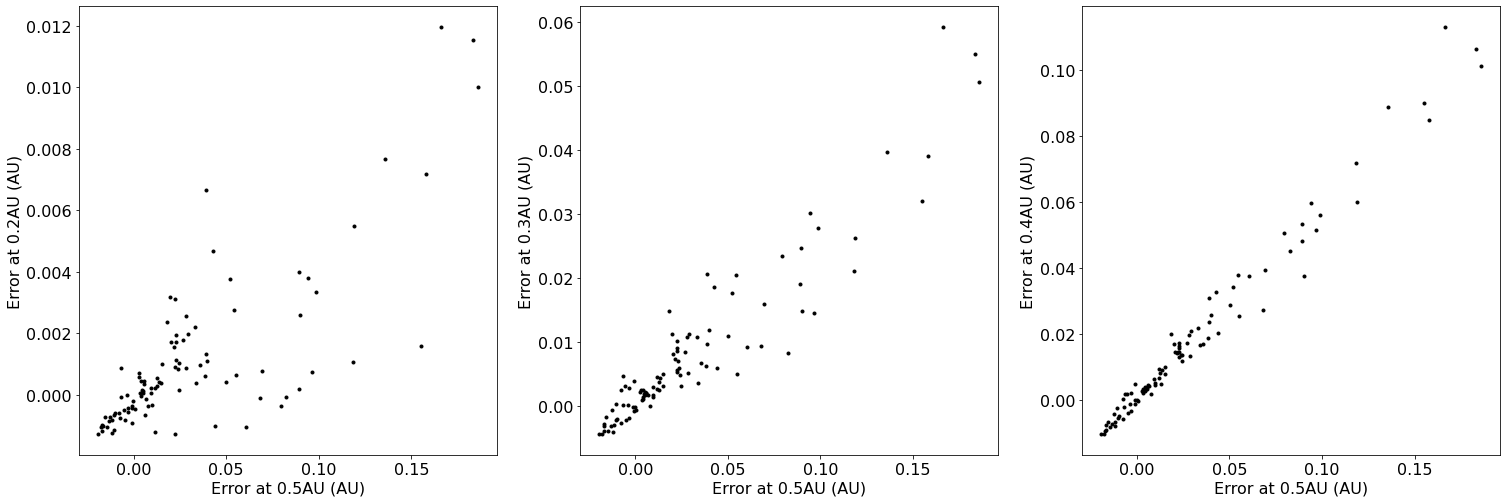

In [64]:

fig, ax = plt.subplots(1, 3, figsize=(21,7))
axr = ax.ravel()

#corr = np.zeros((err_arr.shape[0]-1))
for i in range(err_arr.shape[0]-1):
    axr[i].plot(err_arr[-1,:], err_arr[i,:], 'k.')
    
for a in axr:
    a.set_xlabel('Error at 0.5AU (AU)')
    
ax[0].set_ylabel('Error at 0.2AU (AU)')
ax[1].set_ylabel('Error at 0.3AU (AU)')
ax[2].set_ylabel('Error at 0.4AU (AU)')

fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=0.2)

proj_dirs = gmu.get_project_dirs()        
fig_name = "error_correlation.png".format(err_type)
fig_path = os.path.join(proj_dirs['paper_figures'], fig_name)
fig.savefig(fig_path, format='png')
#plt.close('all')

In [47]:
ymaxs

[5.7748197903165565e-05,
 0.0036478539802932267,
 0.012642048226147036,
 0.02369549701486406,
 0.03600106619264249,
 0.04907998666716403,
 0.06250273139052544,
 0.07643497194895868,
 0.09069396033827926,
 0.10488519378293423,
 0.11948732564575817,
 0.13399882886597578,
 0.1522516603999073,
 0.17287190998124677,
 1.0,
 1.0]